# Distribution of NO<sub>2</sub> by CAMS and TROPOMI

### Main goal

Show side by side the total columns of NO<sub>2</sub> from CAMS and TROPOMI datasets.

### Selected period and study area
* Period: 21/06/2021 between 00:00:00 and 18:00:00
* Location: Czech Republic

### TODO
* Add apriori data to calculate component column 

## Imports and supporting functions

In [1]:
"""
Notes:

- The library cartopy needs the following:
sudo apt-get install libproj-dev proj-data proj-bin 
sudo apt-get install libgeos-dev 
sudo pip install cython

- eccodes must be installed to be able to read grib files (Linux)
Reference: https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a
"""

'\nNotes:\n\n- The library cartopy needs the following:\nsudo apt-get install libproj-dev proj-data proj-bin \nsudo apt-get install libgeos-dev \nsudo pip install cython\n\n- eccodes must be installed to be able to read grib files (Linux)\nReference: https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a\n'

In [2]:
from sentinelsat.sentinel import SentinelAPI
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math

In [3]:
%run functions.ipynb

In [4]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define study area

In [5]:
# Define limit latitudes and longitudes
lat_min = 48.5
lat_max = 51.1
lon_min = 12
lon_max = 18.9

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

## 2. Define datasets

In [6]:
# Define component
component = 'nitrogen_dioxide'
component_nom = 'NO2'
component_mol_weight = 46.005 #g/mol

# CAMS: Define period
start_date = '2021-06-21'
end_date = '2021-06-21'

# TROPOMI: Define file and product name
file_name = 'd762cc7a-f037-4fb8-bc04-cac8e7f39f5b'
product_name = 'S5P_NRTI_L2__NO2____20210621T124026_20210621T124526_19112_01_010400_20210621T132518.nc'

"""
# Currently available datasets to download
# CAMS: Define period
start_date = '2021-07-21'
end_date = '2021-07-21'

# TROPOMI: Define file and product name
file_name = '42ceb065-e6e8-4783-9e6b-4a01d266f54d'
product_name = 'S5P_NRTI_L2__NO2____20210721T113737_20210721T114237_19537_02_020200_20210721T124127.nc'
"""

"\n# Currently available datasets to download\n# CAMS: Define period\nstart_date = '2021-07-21'\nend_date = '2021-07-21'\n\n# TROPOMI: Define file and product name\nfile_name = '42ceb065-e6e8-4783-9e6b-4a01d266f54d'\nproduct_name = 'S5P_NRTI_L2__NO2____20210721T113737_20210721T114237_19537_02_020200_20210721T124127.nc'\n"

## 3. TROPOMI data

### Collect and read data as xarray

In [7]:
#TROPOMI_download(file_name, component_nom)
TROPOMI_ds = TROPOMI_read(product_name, component_nom)
TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

### Calculate pressure

In [8]:
# Read support data to calculate pressure
support_ds = xr.open_dataset('data/tropomi/' + component_nom + '/' + product_name, group = 'PRODUCT/SUPPORT_DATA/INPUT_DATA')

# Calculate pressure as p = ap + b * ps
# Units: ap(Pa) + b(none) * ps(Pa) -> To hPa
pressure_upper_bound = (TROPOMI_ds.tm5_constant_a.sel(vertices = 1) + 
                        TROPOMI_ds.tm5_constant_b.sel(vertices = 1) * support_ds.surface_pressure)

pressure_lower_bound = (TROPOMI_ds.tm5_constant_a.sel(vertices = 0) + 
                        TROPOMI_ds.tm5_constant_b.sel(vertices = 0) * support_ds.surface_pressure)

pressure_half = (pressure_upper_bound + pressure_lower_bound) / 2

TROPOMI_ds = TROPOMI_ds.assign(pressure = pressure_half)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, time, scanline, ground_pixel) float32 ...

### Reduce data to study area

In [9]:
"""
# Create dataframe with scanlines and ground pixels
TROPOMI_coords_df = []
TROPOMI_coords_df = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), 
                          columns = ['ground_pixel', 'scanline'])

# Find corresponding latitudes and longitudes                          
for index, row in TROPOMI_coords_df.iterrows():
    
    TROPOMI_coords_df.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(
                                              scanline = TROPOMI_coords_df['scanline'].loc[index], 
                                              ground_pixel = TROPOMI_coords_df['ground_pixel'].loc[index],
                                              method = None).values
                                        
    TROPOMI_coords_df.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(
                                               scanline = TROPOMI_coords_df['scanline'].loc[index], 
                                               ground_pixel = TROPOMI_coords_df['ground_pixel'].loc[index],
                                               method = None).values

# Save as csv
TROPOMI_coords_df.to_csv('data/tropomi/TROPOMI_coords_df_' + product_name + '.csv', index = False)
"""

"\n# Create dataframe with scanlines and ground pixels\nTROPOMI_coords_df = []\nTROPOMI_coords_df = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), \n                          columns = ['ground_pixel', 'scanline'])\n\n# Find corresponding latitudes and longitudes                          \nfor index, row in TROPOMI_coords_df.iterrows():\n    \n    TROPOMI_coords_df.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(\n                                              scanline = TROPOMI_coords_df['scanline'].loc[index], \n                                              ground_pixel = TROPOMI_coords_df['ground_pixel'].loc[index],\n                                              method = None).values\n                                        \n    TROPOMI_coords_df.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(\n                                               scanline = TROPOMI_coords_df['scanline'].loc[index], \n                                             

In [10]:
# Read csv
TROPOMI_coords_df = pd.read_csv('data/tropomi/TROPOMI_coords_df_' + product_name + '.csv')

# Set limits
TROPOMI_coords_df = TROPOMI_coords_df[(TROPOMI_coords_df['latitude'] >= lat_min) & (TROPOMI_coords_df['latitude'] <= lat_max)]
TROPOMI_coords_df = TROPOMI_coords_df[(TROPOMI_coords_df['longitude'] >= lon_min) & (TROPOMI_coords_df['longitude'] <= lon_max)]

TROPOMI_coords_df

,ground_pixel,scanline,latitude,longitude
144534,387.0,183.0,48.546898,12.072847
144535,387.0,184.0,48.595726,12.062323
144536,387.0,185.0,48.644573,12.051785
144537,387.0,186.0,48.693401,12.041157
144538,387.0,187.0,48.742229,12.030693
...,...,...,...,...
164355,440.0,235.0,50.872116,18.894257
164356,440.0,236.0,50.920200,18.891136
164357,440.0,237.0,50.968403,18.888002
164358,440.0,238.0,51.016579,18.885010


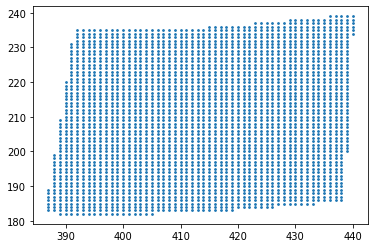

In [11]:
plt.scatter(TROPOMI_coords_df['ground_pixel'], TROPOMI_coords_df['scanline'], s = 3)

In [12]:
# Get scanline and ground pixel coordinates
scanline_coords = np.unique(TROPOMI_coords_df['scanline'].values).tolist()
ground_pixel_coords = np.unique(TROPOMI_coords_df['ground_pixel'].values).tolist()

In [13]:
# Set limits
TROPOMI_ds = TROPOMI_ds.sel(scanline = scanline_coords, ground_pixel = ground_pixel_coords)
TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 54, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 58, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, time, scanline, ground_pixel) float32 ...

In [14]:
# Create dataframe with scanlines and ground pixels
TROPOMI_coords_df_2 = []
TROPOMI_coords_df_2 = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), 
                          columns = ['ground_pixel', 'scanline'])

# Find corresponding latitudes and longitudes                          
for index, row in TROPOMI_coords_df_2.iterrows():
    TROPOMI_coords_df_2.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(
                                              scanline = TROPOMI_coords_df_2['scanline'].loc[index], 
                                              ground_pixel = TROPOMI_coords_df_2['ground_pixel'].loc[index],
                                              method = None).values
                                        
    TROPOMI_coords_df_2.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(
                                               scanline = TROPOMI_coords_df_2['scanline'].loc[index], 
                                               ground_pixel = TROPOMI_coords_df_2['ground_pixel'].loc[index],
                                               method = None).values

# Save as csv
TROPOMI_coords_df_2

,ground_pixel,scanline,latitude,longitude
0,387.0,182.0,48.498062,12.083351
1,387.0,183.0,48.546898,12.072847
2,387.0,184.0,48.595726,12.062323
3,387.0,185.0,48.644573,12.051785
4,387.0,186.0,48.693401,12.041157
...,...,...,...,...
3127,440.0,235.0,50.872116,18.894257
3128,440.0,236.0,50.920200,18.891136
3129,440.0,237.0,50.968403,18.888002
3130,440.0,238.0,51.016579,18.885010


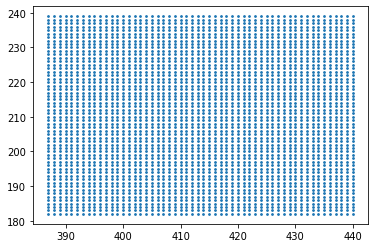

In [15]:
# ERROR: The selected values for the study area are not sliced properly! (there are extra points)
plt.scatter(TROPOMI_coords_df_2['ground_pixel'], TROPOMI_coords_df_2['scanline'], s = 3)

### Calculate column averaging kernels

In [16]:
kernel_column_da = xr.where(TROPOMI_ds.layer > TROPOMI_ds.tm5_tropopause_layer_index, 0, 
                            TROPOMI_ds.averaging_kernel * (TROPOMI_ds.air_mass_factor_total / 
                            TROPOMI_ds.air_mass_factor_troposphere))

TROPOMI_ds = TROPOMI_ds.assign(kernel_column = kernel_column_da)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 54, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 58, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, time, scanline, ground_pixel) float32 ...
    kernel_column                                         (layer, time, scanline, ground_pixel) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [17]:
TROPOMI_ds['TROPOMI_column'] = TROPOMI_ds.TROPOMI_column * 6.02214*10**19

## 4. CAMS data

### Collect and read data as xarray

In [18]:
#CAMS_download(start_date, end_date, component, component_nom)
CAMS_ds = CAMS_read(start_date, end_date, component, component_nom)
CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-03T14:49 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [19]:
# Read csv table with 137 levels
CAMS_levels = pd.read_csv('data/ads/137-levels.csv')

# Drop first row and set n as index hybrid
CAMS_levels = CAMS_levels.drop(0).reset_index(drop = True)
CAMS_levels = CAMS_levels.set_index('n')
CAMS_levels.index.names = ['hybrid']

# Change important columns to numeric
CAMS_levels['ph [Pa]'] = pd.to_numeric(CAMS_levels['ph [hPa]']) * 100
CAMS_levels['Geopotential Altitude [m]'] = pd.to_numeric(CAMS_levels['Geopotential Altitude [m]'])
CAMS_levels['Density [kg/m^3]'] = pd.to_numeric(CAMS_levels['Density [kg/m^3]'])

# Calculate half pressures
CAMS_levels['ph-diff [Pa]'] = CAMS_levels['ph [Pa]'].diff(1)
CAMS_levels['ph-diff [Pa]'].iloc[0] = CAMS_levels['ph [Pa]'].iloc[0]

# Calculate difference from geopotential altitude
CAMS_levels['Depth [m]'] = CAMS_levels['Geopotential Altitude [m]'].diff(-1)
CAMS_levels['Depth [m]'].iloc[-1] = CAMS_levels['Geopotential Altitude [m]'].iloc[-1]

CAMS_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Collect pressure surface data
    Not available

### Reduce data to study area

In [20]:
# Get nearest longitude and latitude to bbox
lon_min_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[0][0])
lon_max_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[1][0])
lat_min_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[0][1])
lat_max_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[1][1])

# Define slices
slice_lat = slice(lat_min_index, lat_max_index + 1)
slice_lon = slice(lon_min_index, lon_max_index + 1)

# Set limits
CAMS_ds = CAMS_ds.isel(longitude = slice_lon, latitude = slice_lat)

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-06-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-06-21 ... 2021-06-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-03T14:49 GRIB to CDM+CF via cfgrib-0.9.9...

### Linear interpolation of CAMS data to 100x100

In [21]:
#CAMS_ds =  CAMS_interpolation(CAMS_ds, TROPOMI_ds, lon_min, lon_max, lat_min, lat_max, component_nom)

### Calculate NO<sub>2</sub> partial column (kg/m<sup>2</sup>) above each CAMS half level

#### OPTION 1

In [22]:
"""
g = 9.81
gi = 1/g #s2/m

da = []
da_hybrid = []

# Initialize partial columns at the top of the atmosphere as 0
PC_0 = 0 * CAMS_ds.sel(hybrid = 1)
da_hybrid.append(PC_0)
CAMS_ds_PC = xr.concat(da_hybrid, dim = 'hybrid')

for hybrid in range(1, CAMS_ds.hybrid.size):

    PC_last = CAMS_ds_PC.sel(hybrid = hybrid)
    component = CAMS_ds.sel(hybrid = hybrid + 1)
    
    # Units: Component(kg/kg) * ph-diff(Pa = kg/m*s2)) * s2/m -> To kg/m2
    PC_da = PC_last + component * CAMS_levels['ph-diff [Pa]'].loc[hybrid] * gi
    
    da_hybrid.append(PC_da)
    CAMS_ds_PC = xr.concat(da_hybrid, pd.Index(range(1, hybrid + 2), name = 'hybrid'))

CAMS_ds = CAMS_ds_PC
CAMS_ds
"""

"\ng = 9.81\ngi = 1/g #s2/m\n\nda = []\nda_hybrid = []\n\n# Initialize partial columns at the top of the atmosphere as 0\nPC_0 = 0 * CAMS_ds.sel(hybrid = 1)\nda_hybrid.append(PC_0)\nCAMS_ds_PC = xr.concat(da_hybrid, dim = 'hybrid')\n\nfor hybrid in range(1, CAMS_ds.hybrid.size):\n\n    PC_last = CAMS_ds_PC.sel(hybrid = hybrid)\n    component = CAMS_ds.sel(hybrid = hybrid + 1)\n    \n    # Units: Component(kg/kg) * ph-diff(Pa = kg/m*s2)) * s2/m -> To kg/m2\n    PC_da = PC_last + component * CAMS_levels['ph-diff [Pa]'].loc[hybrid] * gi\n    \n    da_hybrid.append(PC_da)\n    CAMS_ds_PC = xr.concat(da_hybrid, pd.Index(range(1, hybrid + 2), name = 'hybrid'))\n\nCAMS_ds = CAMS_ds_PC\nCAMS_ds\n"

#### OPTION 2

In [23]:
# Create xarray object from levels df
CAMS_levels_ds = CAMS_levels.to_xarray()

# From kg/kg to kg/m3
CAMS_ds = CAMS_ds * CAMS_levels_ds['Density [kg/m^3]']

# From kg/m3 to kg/m2
CAMS_ds = CAMS_ds * CAMS_levels_ds['Depth [m]']

### Convert CAMS data units (kg/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [24]:
# From kg/m2 to molecules/cm2
NA = 6.022*10**23
CAMS_ds = (CAMS_ds * NA * 1000) / (10000 * component_mol_weight)
CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-06-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-06-21 ... 2021-06-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float64 4.048e+11 ... 9.2...

## 5. Apply averaging kernels

### Transform TROPOMI dataset into a dataframe

In [26]:
TROPOMI_df = TROPOMI_ds.to_dataframe()

TROPOMI_df = TROPOMI_df.drop(columns=['nitrogendioxide_tropospheric_column_precision', 
                                      'nitrogendioxide_tropospheric_column_precision_kernel',
                                      'averaging_kernel',
                                      'air_mass_factor_troposphere',
                                      'air_mass_factor_total',
                                      'tm5_tropopause_layer_index',
                                      'tm5_constant_a',
                                      'tm5_constant_b',
                                      'time_utc'])

# Pass NaNs to data with qa_value under 0.5
TROPOMI_df.loc[TROPOMI_df['qa_value'] < 0.5, ['TROPOMI_column', 'kernel_column']] = float('NaN')

# Drop levels and reorder
TROPOMI_df = TROPOMI_df.droplevel(['corner', 'intensity_offset_polynomial_exponents', 'polynomial_exponents']).drop_duplicates()
TROPOMI_df = TROPOMI_df.groupby(by = ['layer', 'pressure', 'scanline', 'ground_pixel', 'time', 'delta_time']).mean()
TROPOMI_df = TROPOMI_df.reset_index(level = ['layer', 'delta_time'])
TROPOMI_df

layer              delta_time  \
pressure     scanline ground_pixel time                                        
87243.953125 229.0    418.0        2021-06-21    0.0 2021-06-21 12:43:32.952   
87900.632812 192.0    401.0        2021-06-21    0.0 2021-06-21 12:43:01.872   
88025.593750 192.0    400.0        2021-06-21    0.0 2021-06-21 12:43:01.872   
88304.007812 193.0    400.0        2021-06-21    0.0 2021-06-21 12:43:02.712   
88384.671875 228.0    418.0        2021-06-21    0.0 2021-06-21 12:43:32.112   
...                                              ...                     ...   
9.304465     239.0    436.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      437.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      438.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      439.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      440.0        2021-06-21   33.0 2021-06-21 12:43:41.351   

                                                latitude  longitude  qa_value  \
pressure     scanline ground_pixel time                                         
87243.953125 229.0    418.0        2021-06-21  50.744083  15.669636      0.74   
87900.632812 192.0    401.0        2021-06-21  48.992073  13.550930      1.00   
88025.593750 192.0    400.0        2021-06-21  48.992691  13.429176      1.00   
88304.007812 193.0    400.0        2021-06-21  49.041451  13.419986      1.00   
88384.671875 228.0    418.0        2021-06-21  50.695518  15.675993      0.74   
...                                                  ...        ...       ...   
9.304465     239.0    436.0        2021-06-21  51.093616  18.428249      1.00   
                      437.0        2021-06-21  51.086693  18.539761      1.00   
                      438.0        2021-06-21  51.079575  18.652542      1.00   
                      439.0        2021-06-21  51.072258  18.766626      1.00   
                      440.0        2021-06-21  51.064732  18.882040      1.00   

                                               TROPOMI_column  kernel_column  
pressure     scanline ground_pixel time                                       
87243.953125 229.0    418.0        2021-06-21    1.327695e+15       0.048624  
87900.632812 192.0    401.0        2021-06-21    9.852745e+14       0.109274  
88025.593750 192.0    400.0        2021-06-21    1.352566e+15       0.156241  
88304.007812 193.0    400.0        2021-06-21    1.335530e+15       0.158627  
88384.671875 228.0    418.0        2021-06-21    1.244296e+15       0.070985  
...                                                       ...            ...  
9.304465     239.0    436.0        2021-06-21    1.716015e+15       0.000000  
                      437.0        2021-06-21    1.962079e+15       0.000000  
                      438.0        2021-06-21    1.898344e+15       0.000000  
                      439.0        2021-06-21    2.213572e+15       0.000000  
                      440.0        2021-06-21    2.239043e+15       0.000000  

[106488 rows x 7 columns]

In [27]:
match_df = TROPOMI_df
match_df

layer              delta_time  \
pressure     scanline ground_pixel time                                        
87243.953125 229.0    418.0        2021-06-21    0.0 2021-06-21 12:43:32.952   
87900.632812 192.0    401.0        2021-06-21    0.0 2021-06-21 12:43:01.872   
88025.593750 192.0    400.0        2021-06-21    0.0 2021-06-21 12:43:01.872   
88304.007812 193.0    400.0        2021-06-21    0.0 2021-06-21 12:43:02.712   
88384.671875 228.0    418.0        2021-06-21    0.0 2021-06-21 12:43:32.112   
...                                              ...                     ...   
9.304465     239.0    436.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      437.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      438.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      439.0        2021-06-21   33.0 2021-06-21 12:43:41.351   
                      440.0        2021-06-21   33.0 2021-06-21 12:43:41.351   

                                                latitude  longitude  qa_value  \
pressure     scanline ground_pixel time                                         
87243.953125 229.0    418.0        2021-06-21  50.744083  15.669636      0.74   
87900.632812 192.0    401.0        2021-06-21  48.992073  13.550930      1.00   
88025.593750 192.0    400.0        2021-06-21  48.992691  13.429176      1.00   
88304.007812 193.0    400.0        2021-06-21  49.041451  13.419986      1.00   
88384.671875 228.0    418.0        2021-06-21  50.695518  15.675993      0.74   
...                                                  ...        ...       ...   
9.304465     239.0    436.0        2021-06-21  51.093616  18.428249      1.00   
                      437.0        2021-06-21  51.086693  18.539761      1.00   
                      438.0        2021-06-21  51.079575  18.652542      1.00   
                      439.0        2021-06-21  51.072258  18.766626      1.00   
                      440.0        2021-06-21  51.064732  18.882040      1.00   

                                               TROPOMI_column  kernel_column  
pressure     scanline ground_pixel time                                       
87243.953125 229.0    418.0        2021-06-21    1.327695e+15       0.048624  
87900.632812 192.0    401.0        2021-06-21    9.852745e+14       0.109274  
88025.593750 192.0    400.0        2021-06-21    1.352566e+15       0.156241  
88304.007812 193.0    400.0        2021-06-21    1.335530e+15       0.158627  
88384.671875 228.0    418.0        2021-06-21    1.244296e+15       0.070985  
...                                                       ...            ...  
9.304465     239.0    436.0        2021-06-21    1.716015e+15       0.000000  
                      437.0        2021-06-21    1.962079e+15       0.000000  
                      438.0        2021-06-21    1.898344e+15       0.000000  
                      439.0        2021-06-21    2.213572e+15       0.000000  
                      440.0        2021-06-21    2.239043e+15       0.000000  

[106488 rows x 7 columns]

### Combine data (nearest neighbours)

In [28]:
#match_df = match_df.reset_index(level = ['pressure'])

In [29]:
"""
CAMS_latitudes = CAMS_ds.latitude.data
CAMS_longitudes = CAMS_ds.longitude.data
CAMS_pressures = CAMS_levels['ph [Pa]'].to_numpy()
CAMS_times = CAMS_ds.valid_time.data

match_df['lat_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_latitudes, row['latitude']), axis = 1)
match_df['lon_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_longitudes, row['longitude']), axis = 1)
match_df['lay_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_pressures, row['pressure']), axis = 1)
match_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_times, row['delta_time']), axis = 1)
match_df['CAMS_time'] = match_df.apply(lambda row: CAMS_ds.valid_time[row['step_index']].values, axis = 1)

match_df['CAMS_component'] = match_df.apply(lambda row: CAMS_ds.component.isel(
                                                        hybrid = int(row['lay_index']), 
                                                        latitude = int(row['lat_index']), 
                                                        longitude = int(row['lon_index']), 
                                                        step = int(row['step_index'])).values, 
                                                        axis = 1)

match_df
"""

"\nCAMS_latitudes = CAMS_ds.latitude.data\nCAMS_longitudes = CAMS_ds.longitude.data\nCAMS_pressures = CAMS_levels['ph [Pa]'].to_numpy()\nCAMS_times = CAMS_ds.valid_time.data\n\nmatch_df['lat_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_latitudes, row['latitude']), axis = 1)\nmatch_df['lon_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_longitudes, row['longitude']), axis = 1)\nmatch_df['lay_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_pressures, row['pressure']), axis = 1)\nmatch_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_times, row['delta_time']), axis = 1)\nmatch_df['CAMS_time'] = match_df.apply(lambda row: CAMS_ds.valid_time[row['step_index']].values, axis = 1)\n\nmatch_df['CAMS_component'] = match_df.apply(lambda row: CAMS_ds.component.isel(\n                                                        hybrid = int(row['lay_index']), \n                                                        latitude = int(row['lat_index

### Combine data (nearest neighbours + vertical interpolation)

#### Prepare dataframe for interpolation

In [30]:
# Create index that includes CAMS pressure levels for all the locations in TROPOMI
new_index = pd.MultiIndex.from_product([CAMS_levels['ph [Pa]'].to_numpy(), 
                                        match_df.index.levels[1], 
                                        match_df.index.levels[2],
                                        match_df.index.levels[3]],
                                        names = ['pressure', 'scanline', 'ground_pixel', 'time'])

new_index

MultiIndex([(     2.0, 182.0, 387.0, '2021-06-21'),
            (     2.0, 182.0, 388.0, '2021-06-21'),
            (     2.0, 182.0, 389.0, '2021-06-21'),
            (     2.0, 182.0, 390.0, '2021-06-21'),
            (     2.0, 182.0, 391.0, '2021-06-21'),
            (     2.0, 182.0, 392.0, '2021-06-21'),
            (     2.0, 182.0, 393.0, '2021-06-21'),
            (     2.0, 182.0, 394.0, '2021-06-21'),
            (     2.0, 182.0, 395.0, '2021-06-21'),
            (     2.0, 182.0, 396.0, '2021-06-21'),
            ...
            (101325.0, 239.0, 431.0, '2021-06-21'),
            (101325.0, 239.0, 432.0, '2021-06-21'),
            (101325.0, 239.0, 433.0, '2021-06-21'),
            (101325.0, 239.0, 434.0, '2021-06-21'),
            (101325.0, 239.0, 435.0, '2021-06-21'),
            (101325.0, 239.0, 436.0, '2021-06-21'),
            (101325.0, 239.0, 437.0, '2021-06-21'),
            (101325.0, 239.0, 438.0, '2021-06-21'),
            (101325.0, 239.0, 439.0, '2021-06-21

In [31]:
# Append original and new indexes and reindex dataframe
match_df = match_df.reindex(match_df.index.append(new_index))
match_df

layer              delta_time  \
pressure      scanline ground_pixel time                                        
87243.953125  229.0    418.0        2021-06-21    0.0 2021-06-21 12:43:32.952   
87900.632812  192.0    401.0        2021-06-21    0.0 2021-06-21 12:43:01.872   
88025.593750  192.0    400.0        2021-06-21    0.0 2021-06-21 12:43:01.872   
88304.007812  193.0    400.0        2021-06-21    0.0 2021-06-21 12:43:02.712   
88384.671875  228.0    418.0        2021-06-21    0.0 2021-06-21 12:43:32.112   
...                                               ...                     ...   
101325.000000 239.0    436.0        2021-06-21    NaN                     NaT   
                       437.0        2021-06-21    NaN                     NaT   
                       438.0        2021-06-21    NaN                     NaT   
                       439.0        2021-06-21    NaN                     NaT   
                       440.0        2021-06-21    NaN                     NaT   

                                                 latitude  longitude  \
pressure      scanline ground_pixel time                               
87243.953125  229.0    418.0        2021-06-21  50.744083  15.669636   
87900.632812  192.0    401.0        2021-06-21  48.992073  13.550930   
88025.593750  192.0    400.0        2021-06-21  48.992691  13.429176   
88304.007812  193.0    400.0        2021-06-21  49.041451  13.419986   
88384.671875  228.0    418.0        2021-06-21  50.695518  15.675993   
...                                                   ...        ...   
101325.000000 239.0    436.0        2021-06-21        NaN        NaN   
                       437.0        2021-06-21        NaN        NaN   
                       438.0        2021-06-21        NaN        NaN   
                       439.0        2021-06-21        NaN        NaN   
                       440.0        2021-06-21        NaN        NaN   

                                                qa_value  TROPOMI_column  \
pressure      scanline ground_pixel time                                   
87243.953125  229.0    418.0        2021-06-21      0.74    1.327695e+15   
87900.632812  192.0    401.0        2021-06-21      1.00    9.852745e+14   
88025.593750  192.0    400.0        2021-06-21      1.00    1.352566e+15   
88304.007812  193.0    400.0        2021-06-21      1.00    1.335530e+15   
88384.671875  228.0    418.0        2021-06-21      0.74    1.244296e+15   
...                                                  ...             ...   
101325.000000 239.0    436.0        2021-06-21       NaN             NaN   
                       437.0        2021-06-21       NaN             NaN   
                       438.0        2021-06-21       NaN             NaN   
                       439.0        2021-06-21       NaN             NaN   
                       440.0        2021-06-21       NaN             NaN   

                                                kernel_column  
pressure      scanline ground_pixel time                       
87243.953125  229.0    418.0        2021-06-21       0.048624  
87900.632812  192.0    401.0        2021-06-21       0.109274  
88025.593750  192.0    400.0        2021-06-21       0.156241  
88304.007812  193.0    400.0        2021-06-21       0.158627  
88384.671875  228.0    418.0        2021-06-21       0.070985  
...                                                       ...  
101325.000000 239.0    436.0        2021-06-21            NaN  
                       437.0        2021-06-21            NaN  
                       438.0        2021-06-21            NaN  
                       439.0        2021-06-21            NaN  
                       440.0        2021-06-21            NaN  

[535572 rows x 7 columns]

In [32]:
# Sort index
match_df = match_df.sort_index()

# Reset index
match_df = match_df.reset_index()
match_df

,pressure,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,TROPOMI_column,kernel_column
0,2.0,182.0,387.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,2.0,182.0,388.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,2.0,182.0,389.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,2.0,182.0,390.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,2.0,182.0,391.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
535567,101325.0,239.0,436.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
535568,101325.0,239.0,437.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
535569,101325.0,239.0,438.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN
535570,101325.0,239.0,439.0,2021-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [33]:
# Find latitudes in CAMS rows with scanlines and ground pixels
match_df['latitude'] = match_df.apply(lambda row: float(TROPOMI_coords_df_2[
                                                        (TROPOMI_coords_df_2['scanline'] == row['scanline']) & 
                                                        (TROPOMI_coords_df_2['ground_pixel'] == row['ground_pixel'])]['latitude'])
                                                        if pd.isnull(row['latitude']) else row['latitude'], 
                                                        axis = 1)
                                                        
# Find longitudes in CAMS rows with scanlines and ground pixels
match_df['longitude'] = match_df.apply(lambda row: float(TROPOMI_coords_df_2[
                                                        (TROPOMI_coords_df_2['scanline'] == row['scanline']) & 
                                                        (TROPOMI_coords_df_2['ground_pixel'] == row['ground_pixel'])]['longitude'])
                                                        if pd.isnull(row['longitude']) else row['longitude'], 
                                                        axis = 1)
                                                        
# Find hybrids in CAMS rows from 137 models table
match_df['hybrid'] = match_df.apply(lambda row: nearest_neighbour(CAMS_levels['ph [Pa]'].to_numpy(), row['pressure']) + 1
                                                if pd.isnull(row['TROPOMI_column']) else math.nan, 
                                                axis = 1)

In [34]:
match_df

,pressure,scanline,ground_pixel,time,layer,delta_time,latitude,longitude,qa_value,TROPOMI_column,kernel_column,hybrid
0,2.0,182.0,387.0,2021-06-21,NaN,NaT,48.498062,12.083351,NaN,NaN,NaN,1.0
1,2.0,182.0,388.0,2021-06-21,NaN,NaT,48.499416,12.186172,NaN,NaN,NaN,1.0
2,2.0,182.0,389.0,2021-06-21,NaN,NaT,48.500648,12.290169,NaN,NaN,NaN,1.0
3,2.0,182.0,390.0,2021-06-21,NaN,NaT,48.501755,12.395366,NaN,NaN,NaN,1.0
4,2.0,182.0,391.0,2021-06-21,NaN,NaT,48.502731,12.501794,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
535567,101325.0,239.0,436.0,2021-06-21,NaN,NaT,51.093616,18.428249,NaN,NaN,NaN,137.0
535568,101325.0,239.0,437.0,2021-06-21,NaN,NaT,51.086693,18.539761,NaN,NaN,NaN,137.0
535569,101325.0,239.0,438.0,2021-06-21,NaN,NaT,51.079575,18.652542,NaN,NaN,NaN,137.0
535570,101325.0,239.0,439.0,2021-06-21,NaN,NaT,51.072258,18.766626,NaN,NaN,NaN,137.0


In [35]:
# Get unique timestep
first_delta_time = TROPOMI_ds['delta_time'].isel(scanline = 0, time = 0).values
unique_step = nearest_neighbour(CAMS_ds.valid_time.data, first_delta_time)
unique_time = CAMS_ds.component.isel(step = unique_step).step.values.astype('timedelta64[h]')

# Get CAMS component data at nearby TROPOMI locations (nearest neighbours)
# Do it only for CAMS rows
match_df['CAMS_component'] = match_df.apply(lambda row: CAMS_ds.component.sel(
                                                        hybrid = row['hybrid'], 
                                                        latitude = row['latitude'], 
                                                        longitude = row['longitude'], 
                                                        step = unique_time, method = 'nearest').values 
                                                        if pd.isnull(row['TROPOMI_column']) else math.nan,
                                                        axis = 1)

# Transform 1D-array data to float
match_df['CAMS_component'] = match_df['CAMS_component'].apply(lambda x: float(x))

In [36]:
# Set multiindex again and sort
match_df = match_df.set_index(['time', 'pressure', 'scanline', 'ground_pixel'])
match_df = match_df.sort_values(['time', 'ground_pixel','scanline', 'pressure'], 
                                ascending = [True, True, True, False])

match_df

layer              delta_time  \
time       pressure      scanline ground_pixel                                  
2021-06-21 101325.000000 182.0    387.0           NaN                     NaT   
           101084.870000 182.0    387.0           NaN                     NaT   
           100822.390000 182.0    387.0           NaN                     NaT   
           100535.620000 182.0    387.0           NaN                     NaT   
           100222.500000 182.0    387.0           NaN                     NaT   
...                                               ...                     ...   
           9.304465      239.0    440.0          33.0 2021-06-21 12:43:41.351   
           6.830000      239.0    440.0           NaN                     NaT   
           4.670000      239.0    440.0           NaN                     NaT   
           3.100000      239.0    440.0           NaN                     NaT   
           2.000000      239.0    440.0           NaN                     NaT   

                                                 latitude  longitude  \
time       pressure      scanline ground_pixel                         
2021-06-21 101325.000000 182.0    387.0         48.498062  12.083351   
           101084.870000 182.0    387.0         48.498062  12.083351   
           100822.390000 182.0    387.0         48.498062  12.083351   
           100535.620000 182.0    387.0         48.498062  12.083351   
           100222.500000 182.0    387.0         48.498062  12.083351   
...                                                   ...        ...   
           9.304465      239.0    440.0         51.064732  18.882040   
           6.830000      239.0    440.0         51.064732  18.882040   
           4.670000      239.0    440.0         51.064732  18.882040   
           3.100000      239.0    440.0         51.064732  18.882040   
           2.000000      239.0    440.0         51.064732  18.882040   

                                                qa_value  TROPOMI_column  \
time       pressure      scanline ground_pixel                             
2021-06-21 101325.000000 182.0    387.0              NaN             NaN   
           101084.870000 182.0    387.0              NaN             NaN   
           100822.390000 182.0    387.0              NaN             NaN   
           100535.620000 182.0    387.0              NaN             NaN   
           100222.500000 182.0    387.0              NaN             NaN   
...                                                  ...             ...   
           9.304465      239.0    440.0              1.0    2.239043e+15   
           6.830000      239.0    440.0              NaN             NaN   
           4.670000      239.0    440.0              NaN             NaN   
           3.100000      239.0    440.0              NaN             NaN   
           2.000000      239.0    440.0              NaN             NaN   

                                                kernel_column  hybrid  \
time       pressure      scanline ground_pixel                          
2021-06-21 101325.000000 182.0    387.0                   NaN   137.0   
           101084.870000 182.0    387.0                   NaN   136.0   
           100822.390000 182.0    387.0                   NaN   135.0   
           100535.620000 182.0    387.0                   NaN   134.0   
           100222.500000 182.0    387.0                   NaN   133.0   
...                                                       ...     ...   
           9.304465      239.0    440.0                   0.0     NaN   
           6.830000      239.0    440.0                   NaN     4.0   
           4.670000      239.0    440.0                   NaN     3.0   
           3.100000      239.0    440.0                   NaN     2.0   
           2.000000      239.0    440.0                   NaN     1.0   

                                                CAMS_component  
time       pressure      scanline ground_pixel       

#### Interpolate CAMS data to TROPOMI pressures

In [37]:
match_df['CAMS_component'] = match_df['CAMS_component'].interpolate()
match_df

layer              delta_time  \
time       pressure      scanline ground_pixel                                  
2021-06-21 101325.000000 182.0    387.0           NaN                     NaT   
           101084.870000 182.0    387.0           NaN                     NaT   
           100822.390000 182.0    387.0           NaN                     NaT   
           100535.620000 182.0    387.0           NaN                     NaT   
           100222.500000 182.0    387.0           NaN                     NaT   
...                                               ...                     ...   
           9.304465      239.0    440.0          33.0 2021-06-21 12:43:41.351   
           6.830000      239.0    440.0           NaN                     NaT   
           4.670000      239.0    440.0           NaN                     NaT   
           3.100000      239.0    440.0           NaN                     NaT   
           2.000000      239.0    440.0           NaN                     NaT   

                                                 latitude  longitude  \
time       pressure      scanline ground_pixel                         
2021-06-21 101325.000000 182.0    387.0         48.498062  12.083351   
           101084.870000 182.0    387.0         48.498062  12.083351   
           100822.390000 182.0    387.0         48.498062  12.083351   
           100535.620000 182.0    387.0         48.498062  12.083351   
           100222.500000 182.0    387.0         48.498062  12.083351   
...                                                   ...        ...   
           9.304465      239.0    440.0         51.064732  18.882040   
           6.830000      239.0    440.0         51.064732  18.882040   
           4.670000      239.0    440.0         51.064732  18.882040   
           3.100000      239.0    440.0         51.064732  18.882040   
           2.000000      239.0    440.0         51.064732  18.882040   

                                                qa_value  TROPOMI_column  \
time       pressure      scanline ground_pixel                             
2021-06-21 101325.000000 182.0    387.0              NaN             NaN   
           101084.870000 182.0    387.0              NaN             NaN   
           100822.390000 182.0    387.0              NaN             NaN   
           100535.620000 182.0    387.0              NaN             NaN   
           100222.500000 182.0    387.0              NaN             NaN   
...                                                  ...             ...   
           9.304465      239.0    440.0              1.0    2.239043e+15   
           6.830000      239.0    440.0              NaN             NaN   
           4.670000      239.0    440.0              NaN             NaN   
           3.100000      239.0    440.0              NaN             NaN   
           2.000000      239.0    440.0              NaN             NaN   

                                                kernel_column  hybrid  \
time       pressure      scanline ground_pixel                          
2021-06-21 101325.000000 182.0    387.0                   NaN   137.0   
           101084.870000 182.0    387.0                   NaN   136.0   
           100822.390000 182.0    387.0                   NaN   135.0   
           100535.620000 182.0    387.0                   NaN   134.0   
           100222.500000 182.0    387.0                   NaN   133.0   
...                                                       ...     ...   
           9.304465      239.0    440.0                   0.0     NaN   
           6.830000      239.0    440.0                   NaN     4.0   
           4.670000      239.0    440.0                   NaN     3.0   
           3.100000      239.0    440.0                   NaN     2.0   
           2.000000      239.0    440.0                   NaN     1.0   

                                                CAMS_component  
time       pressure      scanline ground_pixel       

#### Show vertical interpolation for one location

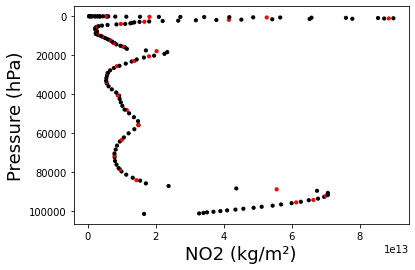

In [38]:
# Query to get data for one location
small = match_df.query('scanline == 182 and ground_pixel == 387')

# Get pressure data
all_pressures = small.index.get_level_values(1).to_numpy()
CAMS_pressures = CAMS_levels['ph [Pa]'].to_numpy()

# Show in black original values and in red the interpolated pressures
diff_colors = np.where(np.isin(all_pressures, CAMS_pressures), 'black', 
                       np.where(~np.isin(all_pressures, CAMS_pressures), 'red', 'yellow'))

# Show component vs. pressures
plt.scatter(small['CAMS_component'], all_pressures, c = diff_colors, s = 10)

# Revert yaxis to have surface pressure on the bottom
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel(f'{component_nom} (molecules/cm²)', fontsize = 18)
ax.set_ylabel('Pressure (Pa)', fontsize = 18)
plt.show()

#### Drop CAMS pressure levels rows
They were meant to be used only for the interpolation

In [39]:
match_df = match_df.drop(CAMS_levels['ph [Pa]'].to_numpy(), level = 'pressure')
match_df

layer              delta_time  \
time       pressure     scanline ground_pixel                                  
2021-06-21 95433.078125 182.0    387.0           0.0 2021-06-21 12:42:53.473   
           94184.875000 182.0    387.0           1.0 2021-06-21 12:42:53.473   
           91988.125000 182.0    387.0           2.0 2021-06-21 12:42:53.473   
           88725.804688 182.0    387.0           3.0 2021-06-21 12:42:53.473   
           84052.070312 182.0    387.0           4.0 2021-06-21 12:42:53.473   
...                                              ...                     ...   
           625.780151   239.0    440.0          29.0 2021-06-21 12:43:41.351   
           309.465515   239.0    440.0          30.0 2021-06-21 12:43:41.351   
           130.429565   239.0    440.0          31.0 2021-06-21 12:43:41.351   
           44.064754    239.0    440.0          32.0 2021-06-21 12:43:41.351   
           9.304465     239.0    440.0          33.0 2021-06-21 12:43:41.351   

                                                latitude  longitude  qa_value  \
time       pressure     scanline ground_pixel                                   
2021-06-21 95433.078125 182.0    387.0         48.498062  12.083351       1.0   
           94184.875000 182.0    387.0         48.498062  12.083351       1.0   
           91988.125000 182.0    387.0         48.498062  12.083351       1.0   
           88725.804688 182.0    387.0         48.498062  12.083351       1.0   
           84052.070312 182.0    387.0         48.498062  12.083351       1.0   
...                                                  ...        ...       ...   
           625.780151   239.0    440.0         51.064732  18.882040       1.0   
           309.465515   239.0    440.0         51.064732  18.882040       1.0   
           130.429565   239.0    440.0         51.064732  18.882040       1.0   
           44.064754    239.0    440.0         51.064732  18.882040       1.0   
           9.304465     239.0    440.0         51.064732  18.882040       1.0   

                                               TROPOMI_column  kernel_column  \
time       pressure     scanline ground_pixel                                  
2021-06-21 95433.078125 182.0    387.0           2.028193e+15       0.247081   
           94184.875000 182.0    387.0           2.028193e+15       0.266311   
           91988.125000 182.0    387.0           2.028193e+15       0.448114   
           88725.804688 182.0    387.0           2.028193e+15       0.724136   
           84052.070312 182.0    387.0           2.028193e+15       0.844962   
...                                                       ...            ...   
           625.780151   239.0    440.0           2.239043e+15       0.000000   
           309.465515   239.0    440.0           2.239043e+15       0.000000   
           130.429565   239.0    440.0           2.239043e+15       0.000000   
           44.064754    239.0    440.0           2.239043e+15       0.000000   
           9.304465     239.0    440.0           2.239043e+15       0.000000   

                                               hybrid  CAMS_component  
time       pressure     scanline ground_pixel                          
2021-06-21 95433.078125 182.0    387.0            NaN    6.125020e+13  
           94184.875000 182.0    387.0            NaN    6.631000e+13  
           91988.125000 182.0    387.0            NaN    7.001520e+13  
           88725.804688 182.0    387.0            NaN    5.550831e+13  
           84052.070312 182.0    387.0            NaN    1.431699e+13  
...                                               ...             ...  
           625.780151   239.0    440.0            NaN    5.157171e+13  
           309.465515   239.0    440.0            NaN    1.746486e+13  
           130.429565   239.0    440.0            NaN    2.814386e+12  
           44.064754    239.0    440.0            NaN    4.569363e+12  
           9.304465     239.0    440.0         

#### Show only interpolated values for one location

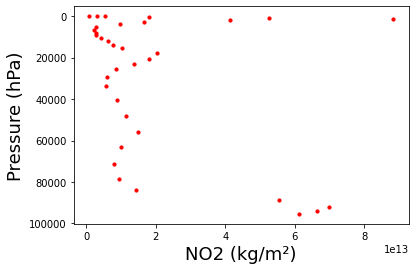

In [40]:
# Query to get data for one location
small = match_df.query('scanline == 182 and ground_pixel == 387')

# Get pressure data
TROPOMI_pressures = small.index.get_level_values(1).to_numpy()

# Show component vs. pressures
plt.scatter(small['CAMS_component'], TROPOMI_pressures, c = 'red', s = 10)

# Revert yaxis to have surface pressure on the bottom
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel(f'{component_nom} (molecules/cm²)', fontsize = 18)
ax.set_ylabel('Pressure (Pa)', fontsize = 18)
plt.show()

#### Calculate CAMS columns

In [41]:
# Calculate values to generate CAMS column to sum in the next step
match_df['CAMS_column'] = match_df.apply(lambda row: row['CAMS_component'] * 
                                                     row['kernel_column'], 
                                                     axis = 1)

In [42]:
match_df = match_df.reset_index('pressure')

#### Continue

In [43]:
match_df = match_df.set_index('layer', append = True)
match_df

pressure              delta_time  \
time       scanline ground_pixel layer                                         
2021-06-21 182.0    387.0        0.0    95433.078125 2021-06-21 12:42:53.473   
                                 1.0    94184.875000 2021-06-21 12:42:53.473   
                                 2.0    91988.125000 2021-06-21 12:42:53.473   
                                 3.0    88725.804688 2021-06-21 12:42:53.473   
                                 4.0    84052.070312 2021-06-21 12:42:53.473   
...                                              ...                     ...   
           239.0    440.0        29.0     625.780151 2021-06-21 12:43:41.351   
                                 30.0     309.465515 2021-06-21 12:43:41.351   
                                 31.0     130.429565 2021-06-21 12:43:41.351   
                                 32.0      44.064754 2021-06-21 12:43:41.351   
                                 33.0       9.304465 2021-06-21 12:43:41.351   

                                         latitude  longitude  qa_value  \
time       scanline ground_pixel layer                                   
2021-06-21 182.0    387.0        0.0    48.498062  12.083351       1.0   
                                 1.0    48.498062  12.083351       1.0   
                                 2.0    48.498062  12.083351       1.0   
                                 3.0    48.498062  12.083351       1.0   
                                 4.0    48.498062  12.083351       1.0   
...                                           ...        ...       ...   
           239.0    440.0        29.0   51.064732  18.882040       1.0   
                                 30.0   51.064732  18.882040       1.0   
                                 31.0   51.064732  18.882040       1.0   
                                 32.0   51.064732  18.882040       1.0   
                                 33.0   51.064732  18.882040       1.0   

                                        TROPOMI_column  kernel_column  hybrid  \
time       scanline ground_pixel layer                                          
2021-06-21 182.0    387.0        0.0      2.028193e+15       0.247081     NaN   
                                 1.0      2.028193e+15       0.266311     NaN   
                                 2.0      2.028193e+15       0.448114     NaN   
                                 3.0      2.028193e+15       0.724136     NaN   
                                 4.0      2.028193e+15       0.844962     NaN   
...                                                ...            ...     ...   
           239.0    440.0        29.0     2.239043e+15       0.000000     NaN   
                                 30.0     2.239043e+15       0.000000     NaN   
                                 31.0     2.239043e+15       0.000000     NaN   
                                 32.0     2.239043e+15       0.000000     NaN   
                                 33.0     2.239043e+15       0.000000     NaN   

                                        CAMS_component   CAMS_column  
time       scanline ground_pixel layer                                
2021-06-21 182.0    387.0        0.0      6.125020e+13  1.513377e+13  
                                 1.0      6.631000e+13  1.765909e+13  
                                 2.0      7.001520e+13  3.137477e+13  
                                 3.0      5.550831e+13  4.019556e+13  
                                 4.0      1.431699e+13  1.209732e+13  
...                                                ...           ...  
           239.0    440.0        29.0     5.157171e+13  0.000000e+00  
                                 30.0     1.746486e+13  0.000000e+00  
                                 31.0     2.814386e+12  0.000000e+00  
                                 32.0     4.569363e+12  0.000000e+00  
                                 33.0     7.407395e+11  0.000000e+00  

[106488 rows x 10 columns]

In [44]:
match_ds = match_df.to_xarray()
match_ds

<xarray.Dataset>
Dimensions:         (ground_pixel: 54, layer: 34, scanline: 58, time: 1)
Coordinates:
  * time            (time) datetime64[ns] 2021-06-21
  * scanline        (scanline) float64 182.0 183.0 184.0 ... 237.0 238.0 239.0
  * ground_pixel    (ground_pixel) float64 387.0 388.0 389.0 ... 439.0 440.0
  * layer           (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 30.0 31.0 32.0 33.0
Data variables:
    pressure        (time, scanline, ground_pixel, layer) float64 9.543e+04 ....
    delta_time      (time, scanline, ground_pixel, layer) datetime64[ns] 2021...
    latitude        (time, scanline, ground_pixel, layer) float64 48.5 ... 51.06
    longitude       (time, scanline, ground_pixel, layer) float64 12.08 ... 1...
    qa_value        (time, scanline, ground_pixel, layer) float32 1.0 ... 1.0
    TROPOMI_column  (time, scanline, ground_pixel, layer) float64 2.028e+15 ....
    kernel_column   (time, scanline, ground_pixel, layer) float32 0.2471 ... 0.0
    hybrid          (time, scanline, ground_pixel, layer) float64 nan ... nan
    CAMS_component  (time, scanline, ground_pixel, layer) float64 6.125e+13 ....
    CAMS_column     (time, scanline, ground_pixel, layer) float64 1.513e+13 ....

In [45]:
# Read latitudes and longitudes from data array
latitude = match_ds.latitude.mean(dim = 'layer')
longitude = match_ds.longitude.mean(dim = 'layer')

In [46]:
# Get sum of CAMS data of each layer to get column data
CAMS = match_ds.CAMS_column.sum(dim = 'layer', skipna = False)
CAMS = CAMS.assign_coords(latitude = latitude, longitude = longitude)
CAMS

<xarray.DataArray 'CAMS_column' (time: 1, scanline: 58, ground_pixel: 54)>
array([[[3.49108481e+14, 3.50082701e+14, 3.19709974e+14, ...,
         2.42680786e+14, 2.44551315e+14, 2.41049141e+14],
        [3.45365378e+14, 3.43684503e+14, 3.18565215e+14, ...,
         2.40287543e+14, 2.38825013e+14, 2.38858042e+14],
        [3.45381489e+14, 3.44380991e+14, 3.17833192e+14, ...,
         2.34940946e+14, 2.36713446e+14, 2.34348223e+14],
        ...,
        [3.55137645e+14, 3.61941036e+14, 3.63948255e+14, ...,
         6.12812887e+14, 6.16611796e+14, 6.12934905e+14],
        [3.58522873e+14, 3.55554609e+14, 3.61859374e+14, ...,
         5.39489643e+14, 5.47863705e+14, 5.45312213e+14],
        [3.49446640e+14, 3.49438437e+14, 3.55136471e+14, ...,
         5.33129573e+14, 5.36785053e+14, 5.44885524e+14]]])
Coordinates:
  * time          (time) datetime64[ns] 2021-06-21
  * scanline      (scanline) float64 182.0 183.0 184.0 ... 237.0 238.0 239.0
  * ground_pixel  (ground_pixel) float64 387.0 388.0 389.0 ... 438.0 439.0 440.0
    latitude      (time, scanline, ground_pixel) float64 48.5 48.5 ... 51.06
    longitude     (time, scanline, ground_pixel) float64 12.08 12.19 ... 18.88

In [47]:
# Get mean of TROPOMI data of each layer (it must be equal)
TROPOMI = match_ds.TROPOMI_column.mean(dim = 'layer', skipna = False)
TROPOMI = TROPOMI.assign_coords(latitude = latitude, longitude = longitude)
TROPOMI

<xarray.DataArray 'TROPOMI_column' (time: 1, scanline: 58, ground_pixel: 54)>
array([[[2.02819298e+15, 1.71451335e+15, 1.93141430e+15, ...,
         1.45532656e+15, 1.10716654e+15, 9.53418712e+14],
        [2.22845279e+15, 2.73555022e+15, 2.09747668e+15, ...,
         1.99942064e+15, 1.86558042e+15, 1.11615882e+15],
        [1.05144602e+15, 1.96068140e+15, 1.97075773e+15, ...,
         2.14389423e+15, 2.01104864e+15, 1.98499780e+15],
        ...,
        [5.07239347e+14, 1.09923472e+15, 6.99258017e+14, ...,
         1.49555126e+15, 1.66586498e+15, 2.24578762e+15],
        [1.08164495e+15, 1.22188343e+15, 5.40617766e+14, ...,
         2.01081129e+15, 2.66609743e+15, 1.60509531e+15],
        [1.05369640e+15, 1.23793594e+15, 1.62317257e+15, ...,
         1.89834376e+15, 2.21357157e+15, 2.23904295e+15]]])
Coordinates:
  * time          (time) datetime64[ns] 2021-06-21
  * scanline      (scanline) float64 182.0 183.0 184.0 ... 237.0 238.0 239.0
  * ground_pixel  (ground_pixel) float64 387.0 388.0 389.0 ... 438.0 439.0 440.0
    latitude      (time, scanline, ground_pixel) float64 48.5 48.5 ... 51.06
    longitude     (time, scanline, ground_pixel) float64 12.08 12.19 ... 18.88

## 6. Merge data

In [48]:
merged_ds = xr.merge([CAMS, TROPOMI])
merged_ds

<xarray.Dataset>
Dimensions:         (ground_pixel: 54, scanline: 58, time: 1)
Coordinates:
  * time            (time) datetime64[ns] 2021-06-21
  * scanline        (scanline) float64 182.0 183.0 184.0 ... 237.0 238.0 239.0
  * ground_pixel    (ground_pixel) float64 387.0 388.0 389.0 ... 439.0 440.0
    latitude        (time, scanline, ground_pixel) float64 48.5 48.5 ... 51.06
    longitude       (time, scanline, ground_pixel) float64 12.08 12.19 ... 18.88
Data variables:
    CAMS_column     (time, scanline, ground_pixel) float64 3.491e+14 ... 5.44...
    TROPOMI_column  (time, scanline, ground_pixel) float64 2.028e+15 ... 2.23...

In [49]:
merged_df = merged_ds.to_dataframe()
merged_df

latitude  longitude   CAMS_column  \
ground_pixel scanline time                                             
387.0        182.0    2021-06-21  48.498062  12.083351  3.491085e+14   
             183.0    2021-06-21  48.546898  12.072847  3.453654e+14   
             184.0    2021-06-21  48.595726  12.062323  3.453815e+14   
             185.0    2021-06-21  48.644573  12.051785  3.365076e+14   
             186.0    2021-06-21  48.693401  12.041157  3.360118e+14   
...                                     ...        ...           ...   
440.0        235.0    2021-06-21  50.872116  18.894257  6.076138e+14   
             236.0    2021-06-21  50.920200  18.891136  6.215097e+14   
             237.0    2021-06-21  50.968403  18.888002  6.129349e+14   
             238.0    2021-06-21  51.016579  18.885010  5.453122e+14   
             239.0    2021-06-21  51.064732  18.882040  5.448855e+14   

                                  TROPOMI_column  
ground_pixel scanline time                        
387.0        182.0    2021-06-21    2.028193e+15  
             183.0    2021-06-21    2.228453e+15  
             184.0    2021-06-21    1.051446e+15  
             185.0    2021-06-21    1.280466e+15  
             186.0    2021-06-21    2.157828e+15  
...                                          ...  
440.0        235.0    2021-06-21    1.962260e+15  
             236.0    2021-06-21    2.333197e+15  
             237.0    2021-06-21    2.245788e+15  
             238.0    2021-06-21    1.605095e+15  
             239.0    2021-06-21    2.239043e+15  

[3132 rows x 4 columns]

## 7. Visualize data

/home/alba/adc-toolbox/env-new/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


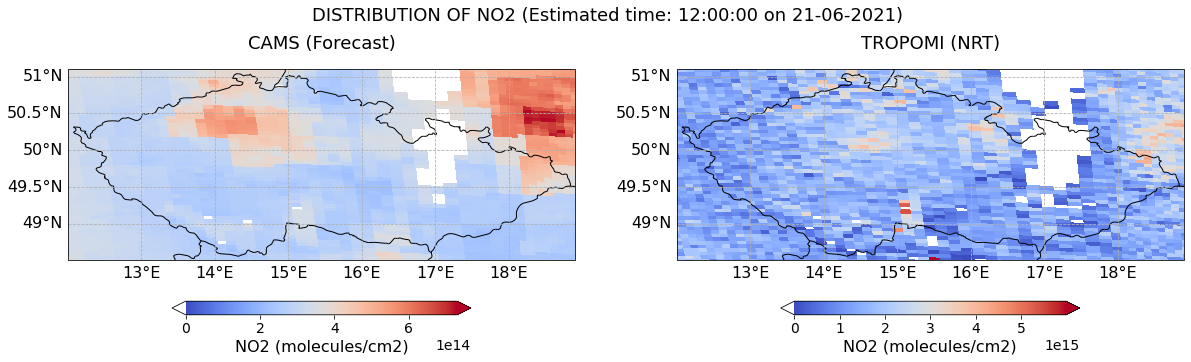

In [50]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for t in range(TROPOMI.time.size):
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})
    
    """
    # Define vmin
    if (np.nanmin(TROPOMI.isel(time = t)) < np.nanmin(CAMS.isel(time = t))) and np.nanmin(TROPOMI.isel(time = t)) >= 0:
        vmin = np.nanmin(TROPOMI.isel(time = t))
    else:
        vmin = np.nanmin(CAMS.isel(time = t))
    
    # Define vmax
    if np.nanmax(TROPOMI.isel(time = t)) < np.nanmax(CAMS.isel(time = t)):
        vmax = np.nanmax(CAMS.isel(time = t))
    else:
        vmax = np.nanmax(TROPOMI.isel(time = t))
    """

    # First plot - CAMS
    array = CAMS.isel(time = t)
    long_name = 'CAMS (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0, 
                        vmax = np.nanmax(CAMS.isel(time = t)), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = TROPOMI.isel(time = t)
    long_name = 'TROPOMI (NRT)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0,  
                        vmax = np.nanmax(TROPOMI.isel(time = t)), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)',
                  fontsize = 18)
    plt.show()

## 8. Compare CAMS original and calculated total columns

In [51]:
#CAMS_tc_download(start_date, end_date, component, component_nom)
CAMS_total_ds = CAMS_tc_read(start_date, end_date, component, component_nom)

In [52]:
# Get nearest longitude and latitude to bbox
lon_min_index = nearest_neighbour(CAMS_total_ds.longitude.data, bbox[0][0])
lon_max_index = nearest_neighbour(CAMS_total_ds.longitude.data, bbox[1][0])
lat_min_index = nearest_neighbour(CAMS_total_ds.latitude.data, bbox[0][1])
lat_max_index = nearest_neighbour(CAMS_total_ds.latitude.data, bbox[1][1])

# Define slices
slice_lat = slice(lat_min_index, lat_max_index + 1)
slice_lon = slice(lon_min_index, lon_max_index + 1)

# Set limits
CAMS_total_ds = CAMS_total_ds.isel(longitude = slice_lon, latitude = slice_lat)

In [53]:
# From kg/m2 to molecules/cm2
CAMS_total_ds = (CAMS_total_ds * NA * 1000) / (10000 * component_mol_weight)
CAMS_total_ds

<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 4)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    tcno2       (step, latitude, longitude) float32 5.861e+15 ... 1.012e+16
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-03T16:12 GRIB to CDM+CF via cfgrib-0.9.9...

/home/alba/adc-toolbox/env-new/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


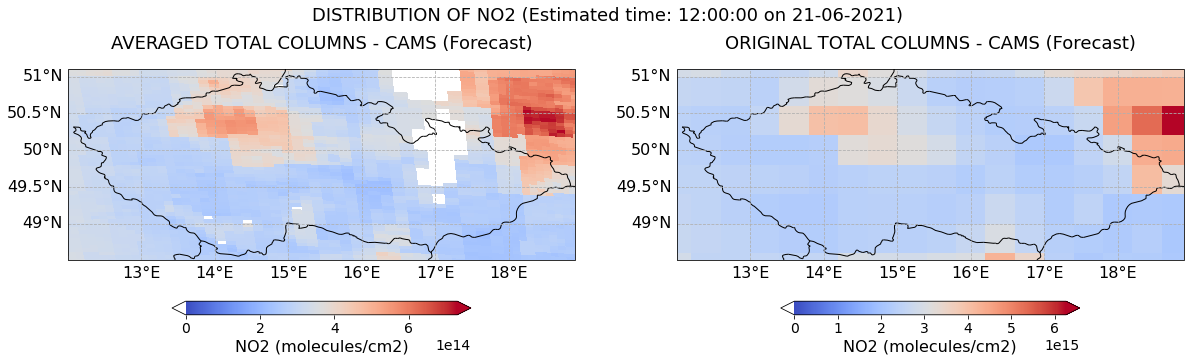

In [54]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for t in range(TROPOMI.time.size):
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})

    # First plot - CAMS
    array = CAMS.isel(time = t)
    long_name = 'AVERAGED TOTAL COLUMNS - CAMS (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0, 
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = CAMS_total_ds.tcno2.isel(step = 2)
    long_name = 'ORIGINAL TOTAL COLUMNS - CAMS (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0,
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)',
                  fontsize = 18)
    plt.show()


## References
### Data sources
* CAMS global atmospheric composition forecasts (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* TROPOMI (https://s5phub.copernicus.eu/dhus)

### Background
* TROPOMI user manual (https://sentinels.copernicus.eu/documents/247904/3119978/Sentinel-5P-Level-2-Input-Output-Data-Definition)

### External functions
* Interpolation (http://christopherbull.com.au/python/scipy-interpolate-griddata/)
* Visualization function (https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb)
* Mask NaN values (https://matplotlib.org/2.0.2/examples/pylab_examples/image_masked.html)
* Convert units (https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710)
* Install eccodes (https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a)